## 安装package

<font color=#FF000 >安装后需要在 jupyter 页面重启  kernel，才会生效</font>  
<font color=#FF000 >必须！python3.7的kernel, 否则会遇到组件兼容性问题</font>

In [ ]:
#（建议）安装最新版本
!pip install --verbose -U fast-causal-inference

## 初始化fast_causal_inference

In [2]:
import fast_causal_inference
#支持业务多租户安全隔离，请首先初始化租户信息才可进行后续使用
fast_causal_inference.set_default(tenant_id='${guest_tenant_id}', tenant_secret_key='${guest_tenant_secret_key}')
sql_instance = fast_causal_inference.create()

### 创建/删除  clickhouse表(视图)
<font color=#FF000 >建议用户基于此function在clickhouse中创建/删除表 </font>  

#### 创建表： 写完整查询SQL

In [3]:
fast_causal_inference.clickhouse_create_view(
                            clickhouse_view_name="a20231018_bearlyhuang4", 
                            sql_statement="""
                            WITH (
                                    SELECT
                                            OlsState(y,x1,x2) AS model
                                    FROM
                                            test_data_small
                                   ) AS model
                              SELECT
                                    evalMLMethod (model,x1,x2) AS y_pre
                              FROM
                                    test_data_small
                              limit 10""",
                              is_sql_complete=True, is_use_local=False)
"""
    创建实验指标明细视图:sql_statement, sql_table_name, sql_where, sql_group_by, sql_limit 会组成完整sql
参数：
    :param clickhouse_view_name: clikchouse视图/物理表名称
    :param sql_statement:  查询子语句 如果is_sql_complete为True, 则为创建表的完整查询
    :param is_sql_complete(默认False) sql_statement字段是否提供的是完整的sql声明,  如果为True，则不需要额外提供sql_table_name, sql_where, sql_group_by, sql_limit 
"""

running, please wait
[2023-10-18 21:56:50] clickhouse.py line:532 INFO - 3
donetime cost: 1.3996154814958572 Seconds


'\n    创建实验指标明细视图:sql_statement, sql_table_name, sql_where, sql_group_by, sql_limit 会组成完整sql\n参数：\n    :param clickhouse_view_name: clikchouse视图/物理表名称\n    :param sql_statement:  查询子语句 如果is_sql_complete为True, 则为创建表的完整查询\n    :param is_sql_complete(默认False) sql_statement字段是否提供的是完整的sql声明,  如果为True，则不需要额外提供sql_table_name, sql_where, sql_group_by, sql_limit \n'

#### 删除表

In [4]:
fast_causal_inference.clickhouse_drop_view(clickhouse_view_name="a20231018_bearlyhuang4") 
"""
    在集群删除视图/物理表, 删除操作需谨慎
    :param clickhouse_view_name:  视图或物理表名称
"""

running, please wait
donetime cost: 0.4244374483823776 Seconds


'\n    在集群删除视图/物理表, 删除操作需谨慎\n    :param clickhouse_view_name:  视图或物理表名称\n'

## 将外部数据导到clickhouse里
如果只是想试用，不需要导入自己的数据做分析，可以跳过这一步

#### tdw数据: thive表 >> clickhouse（通过spark）

In [ ]:
# 申请sparkSession
spark = fast_causal_inference.get_spark_session(group_id='', gaia_id='') # group_id,gaia_id 参考 notebook上默认文件！Spark 资源池.html
# spark = fast_causal_inference.get_spark_session(group_id='', gaia_id='',driver_cores=4, driver_memory="8g", executor_cores=2, executor_memory="10g", spark_eventLog_compress="false")

In [ ]:
# thive dataframe
from pytoolkit import TDWSQLProvider
tdw= TDWSQLProvider(spark, 
                    user='tdw_rtx',# tdw账号："tdw_rtx"
                    passwd='', #查看tdw账号密码 ${tdw_password}
                    db='') # 查询的数据库
thive_df=tdw.table(tblName='', #表名
                   priParts=['p_']) #如果是分区表需要加上所取分区： “p_分区名称” 
# 如果该表已经存在，需要用clickhouse_drop_view将其删除
# fast_causal_inference.clickhouse_drop_view(clickhouse_view_name="test_data_small_20230920_thive")
fast_causal_inference.dataframe_2_clickhouse(dataframe=thive_df, 
                                             clickhouse_table_name="test_data_small_20231017_thive")

#### tdw数据: iceberge表 >> clickhouse（通过spark）

In [ ]:
# 申请sparkSession 需要指定cmk, 下载 ${tdw_cmk} 到notebook
# spark.stop()
spark = fast_causal_inference.get_spark_session(group_id='', gaia_id='', cmk="/home/bearlyhuang/bearlyhuang.cmk")

In [ ]:
# iceberg dataframe
iceberg_df = spark.read.format("iceberg").load("").limit(100) # 数据库.表名称
# 如果该表已经存在，需要用clickhouse_drop_view将其删除
# fast_causal_inference.clickhouse_drop_view(clickhouse_view_name="test_data_small_20231017_iceberg")
fast_causal_inference.dataframe_2_clickhouse(dataframe=iceberg_df, 
                                             clickhouse_table_name="test_data_small_20231017_iceberg")

#### clickhouse >> spark 

In [ ]:
df = fast_causal_inference.clickhouse_2_dataframe(spark, clickhouse_table_name='test_data_small_20230920_thive')
df.show()

#### 本地数据表csv <<>> clickhouse

In [2]:
# csv >> clickhouse    csv文件请将第一行应表示为列名
fast_causal_inference.csv_2_clickhouse(csv_file_abs_path="test_load.csv", clickhouse_table_name="test_load3")

running, please wait
donetime cost: 0.5833354592323303 Seconds


In [3]:
# clickhouse >> csv
fast_causal_inference.clickhouse_2_csv(csv_file_abs_path="test_load2.csv", clickhouse_table_name="test_load3")

running, please wait
donetime cost: 0.749113954603672 Seconds


# 模型使用示例

### 测试分布式数据集：test_data_small

测试数据表: test_data_small 是fake data

In [2]:
sql_instance.sql("desc test_data_small;")

,name,type,default_type,default_expression,comment,codec_expression,ttl_expression
0,id,Int64,,,,,
1,x1,Float64,,,,,
2,x2,Float64,,,,,
3,x3,Float64,,,,,
4,x4,Float64,,,,,
5,x5,Float64,,,,,
6,x_long_tail1,Float64,,,,,
7,x_long_tail2,Float64,,,,,
8,x_cat1,String,,,,,
9,treatment,Int64,,,,,


In [3]:
sql_instance.sql("select * from test_data_small limit 5;")

,id,x1,x2,x3,x4,x5,x_long_tail1,x_long_tail2,x_cat1,treatment,t1,y,numerator_pre,weight,numerator,denominator,denominator_pre
0,156,1.126635922106507,1.3384885094239838,1.8328551818189531,2.992001880776374,3.411340013139924,0.10608597596303615,0.13462216744754896,C,1,1,24.593723892408768,8.552960583941465,0.5539647706685233,24.593723892408768,1,1
1,189,1.5430145954067358,1.0595239303015498,1.250547439864795,3.465457069042979,4.827566453415302,1.710014847954909,0.0402026370799724,B,1,1,13.454691949926122,6.846247286692203,0.16421181697594345,13.454691949926122,1,1
2,258,1.582938397335082,1.175821185240341,0.4048416219996121,1.3274861483760065,2.4829208867768844,0.0256622020706172,0.13563613652058826,A,0,0,6.310380157551421,6.277630789437696,0.7405211064145256,6.310380157551421,1,1
3,270,0.3990463456401302,1.4950341199028865,0.10267331075144027,0.3728201653463098,0.2789308377814992,1.3964133762134665,1.5590047374449285,D,0,0,6.83028091131765,5.532314623663719,0.07384832948304243,6.83028091131765,1,1
4,291,0.4810271184607877,1.4309983256785614,0.18124938655002795,6.4225515882935005,3.2989183198402836,0.0709719819607415,0.507420611165732,A,0,1,0.9458751054056216,1.1695864518718513,0.29882738240783224,0.9458751054056216,1,1


In [4]:
n = sql_instance.sql("select count(*) from test_data_small;")
print("数据表总样本量：",n)

数据表总样本量：   count()
0   10000


## 数据处理工具

### data split       

把数据集按照给定比例分成训练集和测试集，并存入两张新的数据表

In [8]:
from fast_causal_inference.lib.tools import *
table = 'test_data_small'
table_train,table_test = data_split(table,0.5)

running, please wait
donetime cost: 1.4748237580060959 Seconds
running, please wait
donetime cost: 1.5247278213500977 Seconds
running, please wait
donetime cost: 1.4725342318415642 Seconds
running, please wait
donetime cost: 0.5392889603972435 Seconds
table_train: test_data_small_1697641023_train
table_test: test_data_small_1697641023_test


### describe      

对给定表中的数值型列进行描述性分析，包括均值、标准差、最大值、最小值、分位点、样本量

In [9]:
from fast_causal_inference.lib.tools import *
table = 'test_data_small'
describe(table,'*')

,count,std,min,quantile_0.25,quantile_0.5,quantile_0.75,quantile_0.90,quantile_0.99,max
id,10000.0,2886.895680,0.000000,2508.750000,5023.500000,7531.250000,8999.900000,9896.270000,9999.000000
x1,10000.0,0.597495,0.000068,0.308642,0.670117,1.140167,1.632613,2.573959,3.801660
x2,10000.0,1.201742,0.000075,0.634496,1.328577,2.270187,3.269849,5.095239,8.893264
x3,10000.0,0.987922,0.000439,0.291029,0.697518,1.374604,2.270360,4.544576,9.417911
x4,10000.0,1.971388,0.000400,0.560478,1.382331,2.782576,4.638931,9.301886,19.830242
x5,10000.0,1.437626,0.000984,1.228157,2.484281,3.731681,4.464565,4.946469,4.999841
x_long_tail1,10000.0,0.883486,0.000021,0.099514,0.262593,0.595834,1.191102,3.972097,28.065146
x_long_tail2,10000.0,3.048051,0.000002,0.149709,0.406744,0.996520,2.105082,9.333730,156.238517
treatment,10000.0,0.499937,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
t1,10000.0,0.500025,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### histplot      

绘制分布直方图，数值型的列，绘制直方图，并伴有KDE曲线；字符型的列，绘制条形图

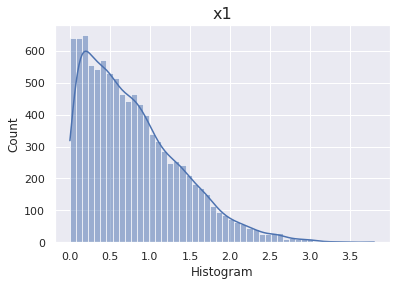

The type of x_cat1 is not numeric


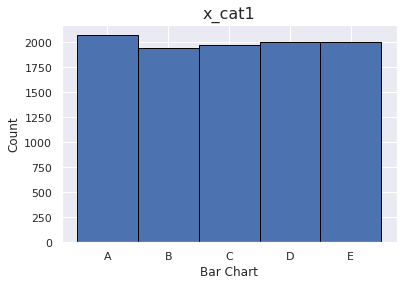

In [5]:
from fast_causal_inference.lib.tools import *
# 数值型的列，绘制直方图，并伴有KDE曲线
table = 'test_data_small'
col = 'x1'
histplot(table,col,bin_num=50)

# 字符型的列，绘制条形图
table = 'test_data_small'
col = 'x_cat1'
histplot(table,col,bin_num=50)

### boxplot  

绘制箱线图

min: 6.835257171676114e-05
25_quantile: 0.30070456351583164
50_quantile: 0.6597333324955622
75_quantile: 1.1372019628384529
max: 3.8016602149671153


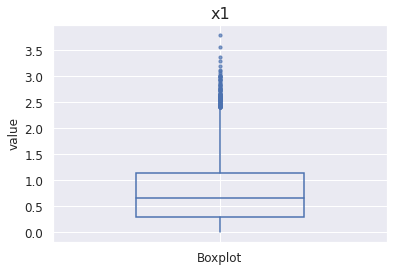

In [6]:
from fast_causal_inference.lib.tools import *

# col必须是数值型的列，只能输入1列。
table = 'test_data_small'
col = 'x1'
# 最小值，1/4分位点，中位数，3/4分位点，最大值。绘制的图片。
boxplot(table,col)

## 因果推断工具

### test和estimator

#### ttest

做双样本t检验，关心的指标是 numerator/denominator，例如点击率指标，numerator代表点击，denominator代表曝光

In [2]:
ttest = sql_instance.sql("""select 
                                  ttest_2samp(avg(numerator)/avg(denominator),treatment,'two-sided') as ttest_result
                            from 
                                  test_data_small""")
# 某个cell ttest结果转pandas
fast_causal_inference.to_pandas(ttest['ttest_result'])

,estimate,stderr,t-statistic,p-value,lower,upper
0,16.438494,0.219140,75.013786,0.000000,16.008882,16.868106


##### ttest with CUPED

In [3]:
ttest = sql_instance.sql("""select 
                                  ttest_2samp(avg(numerator)/avg(denominator),treatment,'two-sided',
                                  avg(numerator_pre)/avg(denominator_pre)) as ttest_result 
                            from 
                                  test_data_small""")
# 某个cell ttest结果转pandas
fast_causal_inference.to_pandas(ttest['ttest_result'])

,estimate,stderr,t-statistic,p-value,lower,upper
0,16.256205,0.173579,93.653167,0.000000,15.915913,16.596498


##### 维度下钻的ttest

In [9]:
ttest = sql_instance.sql("""select 
                                  x_cat1,ttest_2samp(avg(numerator)/avg(denominator),treatment,'two-sided',
                                  avg(numerator_pre)/avg(denominator_pre)) as ttest_result 
                            from 
                                  test_data_small
                            group by 
                                  x_cat1""")
# 某个cell ttest结果转pandas
fast_causal_inference.to_pandas(ttest['ttest_result'])

,estimate,stderr,t-statistic,p-value,lower,upper
0,11.605660,0.391090,29.675148,0.000000,10.838171,12.373149
1,17.699323,0.342373,51.696012,0.000000,17.027411,18.371234
2,17.180807,0.352260,48.773115,0.000000,16.489546,17.872067
3,17.474216,0.383465,45.569312,0.000000,16.721708,18.226724
4,17.279634,0.316981,54.513237,0.000000,16.657639,17.901629


#### SRM

In [4]:
result = sql_instance.sql("""SELECT  
                                   SRM(1, treatment, [1,1]) as srm
                            FROM  
                                   test_data_small""")
fast_causal_inference.to_pandas(result['srm'])

,groupname,f_obs,ratio,chisquare,p-value
0,0,4906.000000,1.000000,3.534400,0.060108
1,1,5094.000000,1.000000,None,None


#### IPW

采用IPW估计量估计ATE，并做假设检验

In [11]:
from fast_causal_inference.lib.estimators import *
Y='y'
T='t1'
table = 'test_data_small'
X = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_long_tail1', 'x_long_tail2']
categorical_columns = ['x_cat1']
IPWestimator(table,Y,T,P='weight',n=100000,B=500)


{'ATE': 101.13761350327832,
 'stddev': 1.8878538312539235,
 'p_value': 0.0,
 'confidence_interval': [97.43741999402063, 104.837807012536]}

### 回归模型

#### OLS

In [6]:
# ols
result = sql_instance.sql(f"""SELECT 
                                    ols(y~x1+x2) AS res
                              FROM
                                    test_data_small""")
print(result)
from fast_causal_inference.lib.ols import Ols
ols_obj = Ols(result['res'][0])
print(ols_obj)
print("estimate", ols_obj.get_estimate())
print("stderr", ols_obj.get_stderr())
print("t_values", ols_obj.get_t_values())
print("pr", ols_obj.get_pr())

                                                 res
0  Call:\n  lm( formula = y ~ x1 + x2 )\n\n  Coef...
Call:
lm(formula = y ~ + x1 + x2)

Coefficients:
		Estimate    Std. Error	t value	    Pr(>|t|)
(Intercept)	4.046845    0.244046    16.58231    0.0         
x1		2.091969    0.193145    10.831074   0.0         
x2		6.261992    0.09603     65.208725   0.0         

Residual standard error: 11.539717 on 9997 degrees of freedom
Multiple R-squared: 0.303999, Adjusted R-squared: 0.303859
F-statistic: 2183.238473 on 2 and 9997 DF,  p-value: 0.0
estimate [4.046845, 2.091969, 6.261992]
stderr [0.244046, 0.193145, 0.09603]
t_values [16.58231, 10.831074, 65.208725]
pr [0.0, 0.0, 0.0]


In [14]:
# predict
#写法1：只适用于在相同数据上做训练和预测
sql_instance.sql(f"""SELECT
                                    predict(olsState(y+x1+x2),x1,x2) AS res
                              FROM
                                    test_data_small
                              limit 10""")

,res
0,14.785336326451935
1,13.909513430256586
2,14.721285276824894
3,14.243529144632323
4,14.014038705472018
5,12.36148792093735
6,25.75146455692826
7,14.109229854143258
8,23.582414432072795
9,16.559592287717535


In [15]:
#写法2:适用于在相同或者不同数据集分别做训练和预测
sql_instance.sql(f"""WITH (
                                    SELECT
                                            OlsState(y,x1,x2) AS model
                                    FROM
                                            test_data_small
                                   ) AS model
                              SELECT
                                    evalMLMethod (model,x1,x2) AS y_pre
                              FROM
                                    test_data_small
                              limit 10""")

,y_pre
0,14.785336326451928
1,13.909513430256581
2,14.721285276824888
3,14.243529144632314
4,14.014038705472007
5,12.361487920937336
6,25.75146455692827
7,14.10922985414325
8,23.58241443207281
9,16.559592287717535


#### WLS

In [7]:
result = sql_instance.sql(f"""SELECT
                                    wls(y~x1+x2,weight) as res
                              from 
                                    test_data_small""")
print(result)
print(result["res"][0])

                                                 res
0  Call:\n  lm( formula = y ~ x1 + x2 )\n\n  Coef...
Call:
  lm( formula = y ~ x1 + x2 )

  Coefficients:
  .               Estimate    Std. Error  t value     Pr(>|t|)    
  (Intercept)     3.870708    0.248230    15.593206   0.000000    
  x1              2.318673    0.196581    11.795025   0.000000    
  x2              6.300006    0.096728    65.130929   0.000000    

  Residual standard error: 8.266985 on 9997 degrees of freedom
  Multiple R-squared: 0.337333, Adjusted R-squared: 0.337201
  F-statistic: 2544.506453 on 2 and 9997 DF,  p-value: 0.000000



#### Lasso

In [2]:
# 训练
ols = sql_instance.sql(f"""SELECT
                                stochasticLinearRegression(0.001, 0.1, 15, 'Lasso')(y, x1, x2, x3) as lasso
                           FROM
                                test_data_small""")
print(ols.to_string())

                                                                            lasso
0  [0.2639738685896894,0.6924030332230416,0.37547697677337344,0.3138251386506572]


In [3]:
# 预测
ols = sql_instance.sql(f"""WITH (
                            SELECT
                                  stochasticLinearRegressionState(0.001, 0.1, 15, 'Lasso')(y, x1, x2, x3) AS model
                            FROM
                                  test_data_small
                            ) AS model
                            SELECT
                                   evalMLMethod(model,x1,x2,x3) AS y_pred
                            FROM
                                   test_data_small
                            limit 10""")
ols

,y_pred
0,1.9992073422380825
1,1.7366716337422385
2,1.5371436559490688
3,1.3435729405915728
4,1.3504002355451
5,1.2258104332174165
6,2.985064366925796
7,1.3773521025791897
8,2.3833991101533063
9,2.2616335915817287


### 观测性分析

#### IV

这里的IV方程如下：  
$$Y = X3_{est} + X1 + X2$$
$$X3 = treatment+X1 + X2$$


In [6]:
# iv 
iv = sql_instance.sql("""
                        SELECT
                              ivregression(y~(t1~treatment)+x1+x2) as iv
                        FROM
                              test_data_small""")
print(iv.to_string())
print(iv["iv"][0])

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    iv
0  Call:\n  lm( formula = y ~ x1 + x2 + x3 )\n\n  Coefficients:\n  .               Estimate    Std. Error  t value     Pr(>|t|)    \n  (Intercept)     -0.936576   0.184904    -5.065214   0.000000    \n  x1              21.801233   0.298340    73.075190   0.000000    \n  x2              0.059430    0.285471    0.208182    0.835091    \n  x3              3.531304    0.182881    19.309288   0.000000  

#### matching

In [7]:
# propensitysocre 匹配
data = sql_instance.sql("""SELECT
                                 treatment,weight,caliperMatching(if(treatment=1,-1,1),weight,0.2) AS matchingIndex
                           FROM
                                 test_data_small
                           WHERE matchingIndex != 0
                           ORDER by abs(matchingIndex)
                           limit 10""")
data

,treatment,weight,matchingIndex
0,0,0.05151360626601853,1
1,1,0.1114289778800367,-1
2,0,0.04563115729039435,2
3,1,0.1758080157794233,-2
4,0,0.09130193974460243,3
5,1,0.1331621099438821,-3
6,1,0.10312681079208352,-4
7,0,0.18475221239031903,4
8,0,0.04837618721275183,5
9,1,0.16253411065605206,-5


In [8]:
# 精确匹配
data = sql_instance.sql("""SELECT
                                 treatment,x_cat1,exactMatching(if(treatment=1,-1,1),x_cat1) as matchingIndex
                           FROM
                                 test_data_small
                           WHERE matchingIndex != 0
                           ORDER by abs(matchingIndex)
                           limit 10""")
data

,treatment,x_cat1,matchingIndex
0,0,B,1
1,1,B,-1
2,1,B,-2
3,0,B,2
4,0,B,3
5,1,B,-3
6,0,B,4
7,1,B,-4
8,1,B,-5
9,0,B,5


### 实验平台

In [12]:
xexpt_ttest = sql_instance.sql("""
SELECT 
    xexpt_ttest_2samp(numerator, denominator, if(groupname = 'B1','B','A'), uin, 0.05, 0.005, 0.8) as xexpt_ttest
FROM
    expt_detail_20203943_bearlyhuang_1697701184478
where
    metric_id = 41474
    and groupname in ('A1','A2','B1');
""")
print(xexpt_ttest['xexpt_ttest'][0])

groupname   numerator   denominator  mean        std_samp    
  A           6856        2071951      0.003309    1.006616    
  B           4615        762813       0.006050    1.077599    

  diff_relative   95%_relative_CI            p-value     t-statistic  diff        95%_CI                   power       recommend_samples 
  82.836244%      [-1.351373%,  167.023861%] 0.053270    1.932725     0.002741    [-0.000045,  0.005527]   0.050016    43993278850       



### Uplift模型

#### causal tree

****STEP1.  Table check.
debug
****STEP2.  Bucket the continuous variables(cut_x_names).
****STEP3.  Create new table for training causaltree:  test_data_small_1695727034_new .
running, please wait
donetime cost: 9.263142044001142 Seconds
	 train data samples: 5011,predict data samples: 4989
****STEP4.  Build tree.
================================== start buildTree -- maxDepth: 2, nodePosition: root==================================
--------start leftNode - build -- depth: 0, nodePosition: LL--------
no split points that satisfy the condition,stop splitting as a leaf node
--------start rightNode - build -- depth: 0, nodePosition: LR--------
--------start leftNode - build -- depth: 1, nodePosition: LRL--------
Reach the maxDepth, stop as a leaf node
--------start rightNode - build -- depth: 1, nodePosition: LRR--------
Reach the maxDepth, stop as a leaf node
============================================== build Tree Sucessfully=====================================================
****STE

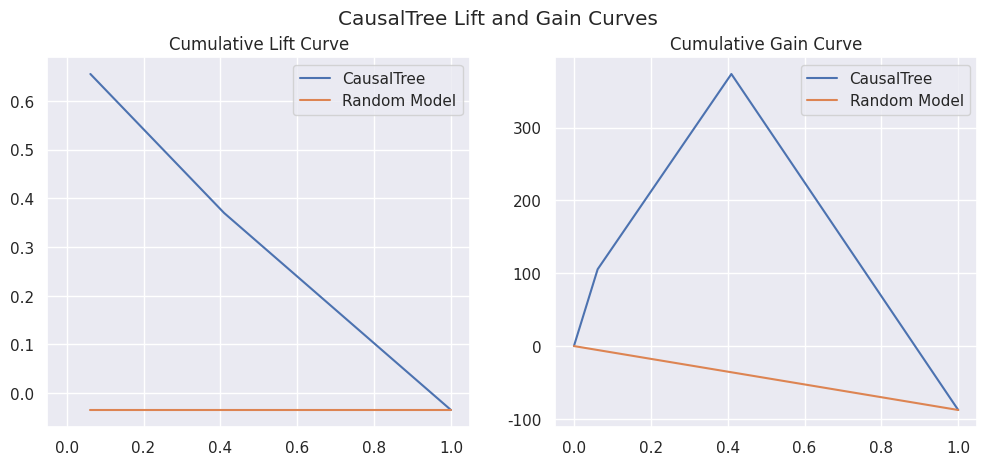

running, please wait
donetime cost: 0.6487586600123905 Seconds
running, please wait
donetime cost: 2.393926336997538 Seconds
running, please wait
donetime cost: 1.7802088680036832 Seconds
running, please wait
donetime cost: 0.48902187499334104 Seconds


In [27]:
from fast_causal_inference.lib.causaltree import CausalTree

Y='y'
T='treatment'
table = 'test_data_small'
X = 'x1+x2+x3+x4+x5+x_long_tail1+x_long_tail2'
needcut_X = 'x1+x2+x3+x4+x5+x_long_tail1+x_long_tail2'

hte = CausalTree(depth = 2)
hte.fit(Y,T,X,needcut_X,table)

# 输出树结构的图（可下载）
treeplot = hte.treeplot()
treeplot.render('digraph.gv', view=False) # 可以在digraph.gv.pdf文件里查看tree的完整图片并下载

# 输出训练集上的uplift curve
hte.hte_plot() 
# 输出变量重要性
hte.feature_importance 
fast_causal_inference.clickhouse_drop_view(clickhouse_view_name="test_table_small_causaltree_dep2") 
hte.effect_2_clickhouse(table_output='test_table_small_causaltree_dep2') # 指定一张带预测的表，预测该表的HTE

In [28]:
hte.feature_importance 

,featName,importance
0,x1_buckets,388.119065
4,x_long_tail2_buckets,377.268796
1,x2_buckets,137.856331
2,x3_buckets,88.030017
3,x4_buckets,11.507805


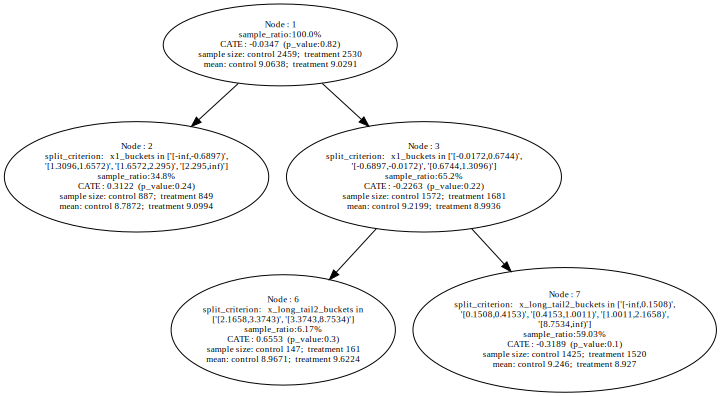

In [29]:
treeplot

#### DML

##### LinearDML  

In [13]:
from fast_causal_inference.lib.linear_dml import *

Y='y'
T='treatment'
table = 'test_data_small'
features = ['x1', 'x2']
X_fordml = '+'.join(features)
W='x3'
model = LinearDML(Y=Y,T=T,X=X_fordml,W=W, model_y="Ols", model_t="stochasticLogisticRegression(1.0, 1.0, 10)", cv=2, table=table)


print(model.summary())
print(model.ate('x1+x2',0,1))
print(model.ate_interval('x1+x2',0,1,alpha=0.05))
print(model.effect('x1+x2',0,1))
clickhouse_drop_view(clickhouse_view_name="test_table_output1") 
model.effect('x1+x2',0,1,table_output='test_table_output1') # effect预测结果存到表里
print(model.effect_interval('x2+x3',0,1,0.05))
clickhouse_drop_view(clickhouse_view_name="test_table_output2") 
model.effect_interval('x1+x2',0,1,0.05,table_output='test_table_output2') # effect预测结果存到表里

		Coefficient Results
		Estimate    Std. Error	t value	    Pr(>|t|)
x0		1.476736    0.209774    7.039634    0.0         
x1		4.791119    0.104205    45.977995   0.0         

		CATE Intercept Results
		Estimate    Std. Error	t value	    Pr(>|t|)
cate_intercept	-0.411417   0.262667    -1.566307   0.117308    

  avg(evalMLMethod(final_model, x1, x2, 1))
0                         8.350150021739521
mean_point	ci_mean_lower	ci_mean_upper	
8.3303375933	8.0869844388	8.5736907478	
               predict
0   7.6830715452068095
1    6.959907064121559
2    7.577251795332628
3    7.358158931979811
4    7.172040598312095
..                 ...
95    8.42863995456323
96  1.0164886773052288
97  4.5293284385760995
98  17.623252383076906
99  3.5405680085627287

[100 rows x 1 columns]
running, please wait
donetime cost: 3.4663355946540833 Seconds
running, please wait
donetime cost: 19.72909963130951 Seconds
   evalMLMethod(final_model, 'confidence', 0.95, x2, x3, 1)
0   [10.362154320085331,10.021765020

##### LinearDML (T进行treatment_featurizer)

In [ ]:
from fast_causal_inference.lib.linear_dml import *
Y='y'
T='treatment'
table = 'test_data_small'
features = ['x1', 'x2']
X_fordml = '+'.join(features)
W='x3'
model = LinearDML(Y=Y,T=T,X=X_fordml,W=W, model_y="ols", model_t="ols", cv=2, table=table, treatment_featurizer=polynomial_features('rand()', 3))
print('\n----summary----')
print(model.summary())
print(model.effect(T0=0.1, T1=0.2))
print(model.const_marginal_effect())
print(model.marginal_effect())
print(model.marginal_ate())

##### NonparamDML

In [16]:
from fast_causal_inference.lib.linear_dml import NonParamDML

Y='y'
T='treatment'
table = 'test_data_small'
features = ['x1', 'x2']
X_fordml = '+'.join(features)
W='x3'

model = NonParamDML(table=table, Y=Y,T=T,X=X_fordml, model_y='Ols', model_t='Ols', cv=2)
print(model.summary())

		Coefficient Results
		Estimate    Std. Error	t value	    Pr(>|t|)
x0		2.384758    0.200711    11.88154    0.0         
x1		9.146569    0.099732    91.711491   0.0         

		CATE Intercept Results
		Estimate    Std. Error	t value	    Pr(>|t|)
cate_intercept	0.003034    0.253375    0.011975    0.990446    



#### Uplift模型评估

这里是对比了用causaltree 不同深度的模型，在预测集上的uplift curve

In [26]:
# 先训练2个模型

from fast_causal_inference.lib.causaltree import CausalTree
Y='y'
T='treatment'
table = 'test_data_small'
X = 'x1+x2+x3+x4+x5+x_long_tail1+x_long_tail2'
needcut_X = 'x1+x2+x3+x4+x5+x_long_tail1+x_long_tail2'

hte = CausalTree(depth = 2)
hte.fit(Y,T,X,needcut_X,table)
fast_causal_inference.clickhouse_drop_view(clickhouse_view_name="test_table_small_causaltree_dep2") 
hte.effect_2_clickhouse(table_output='test_table_small_causaltree_dep2') # 指定一张带预测的表，预测该表的HTE

hte = CausalTree(depth = 2)
hte.fit(Y,T,X,needcut_X,table)
fast_causal_inference.clickhouse_drop_view(clickhouse_view_name="test_table_small_causaltree_dep3") 
hte.effect_2_clickhouse(table_output='test_table_small_causaltree_dep3') # 指定一张带预测的表，预测该表的HTE

****STEP1.  Table check.
debug
****STEP2.  Bucket the continuous variables(cut_x_names).
****STEP3.  Create new table for training causaltree:  test_data_small_1695718932_new .
running, please wait
donetime cost: 8.061152239970397 Seconds
	 train data samples: 5023,predict data samples: 4977
****STEP4.  Build tree.
================================== start buildTree -- maxDepth: 2, nodePosition: root==================================
--------start leftNode - build -- depth: 0, nodePosition: LL--------
no split points that satisfy the condition,stop splitting as a leaf node
--------start rightNode - build -- depth: 0, nodePosition: LR--------
--------start leftNode - build -- depth: 1, nodePosition: LRL--------
Reach the maxDepth, stop as a leaf node
--------start rightNode - build -- depth: 1, nodePosition: LRR--------
Reach the maxDepth, stop as a leaf node
============================================== build Tree Sucessfully=====================================================
****STE

select lift(effect,y,treatment,100,false) from test_table_small_causaltree_dep2
   ratio                  lift                  gain                  ate  \
0   0.01    0.4405831545068281  0.004405831545068281  0.04431271074653015   
1   0.02    0.6367920014036054  0.012735840028072107  0.04431271074653015   
2   0.03    0.7257701743264073   0.02177310522979222  0.04431271074653015   
3   0.04    0.6764420008881616  0.027057680035526468  0.04431271074653015   
4   0.05    0.4809535583151753  0.024047677915758764  0.04431271074653015   
..   ...                   ...                   ...                  ...   
95  0.96   0.03631838804251709    0.0348656525208164  0.04431271074653015   
96  0.97   0.02911600572568093  0.028242525553910502  0.04431271074653015   
97  0.98  0.033020404699716926  0.032359996605722585  0.04431271074653015   
98  0.99  0.022651231795720175  0.022424719477762974  0.04431271074653015   
99   1.0   0.04431271074652142   0.04431271074652142  0.04431271074653015

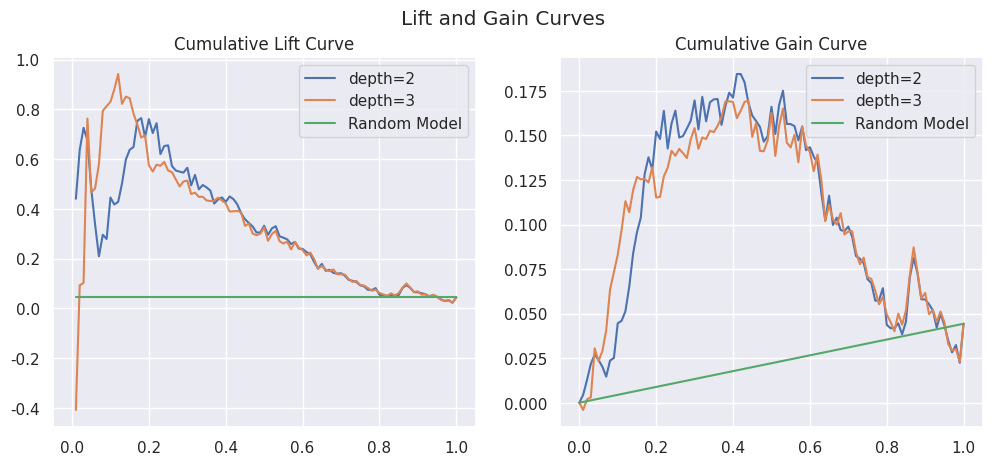

In [32]:
# 对比两个模型的效果

from fast_causal_inference.lib.metrics import *
tmp1 = get_lift_gain("effect", "y", "treatment", "test_table_small_causaltree_dep2",discrete_treatment=False, K=100)
tmp1.summary()
tmp2 = get_lift_gain("effect", "y", "treatment", "test_table_small_causaltree_dep3",discrete_treatment=False, K=100)
tmp2.summary()
hte_plot([tmp1, tmp2],labels=['depth=2','depth=3'])

### ML模型（spark）

采用pyspark做逻辑回归，并把回归后的结果导出到新的表中，预测概率的列名叫'score'  
注意：这里需要申请spark资源

In [ ]:
from fast_causal_inference.lib.ml_spark import *
Y='y'
T='t1'
table = 'test_data_small'
X = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_long_tail1', 'x_long_tail2']
categorical_columns = ['x_cat1']
table_output = LogisticRegression_spark(spark,
                         table,T,X,categorical_columns,
                         maxIter=40, regParam=0, elasticNetParam=0.6)

from fast_causal_inference.lib.tools import *
get_columns(table_output)

******************************
AUC:  0.8825068200041265
******************************
running, please wait
[2023-09-26 17:11:11] tdw.py line:378 INFO - dataframe count=10000
[2023-09-26 17:11:11] tdw.py line:337 INFO - clickhouse table auto create table
donetime cost: 36.0409711439861 Seconds
******************************
table_output: test_data_small_1695719461
******************************


{'id': 'UUID',
 'x1': 'Float64',
 'x2': 'Float64',
 'x3': 'Float64',
 'x4': 'Float64',
 'x5': 'Float64',
 'x_long_tail1': 'Float64',
 'x_long_tail2': 'Float64',
 'x_cat1': 'String',
 'treatment': 'Int64',
 'numerator_pre': 'Float64',
 'denominator_pre': 'Int64',
 'numerator': 'Float64',
 'denominator': 'Int64',
 'y': 'Float64',
 't1': 'Int64',
 'weight': 'Float64',
 'score': 'Float32',
 'day_': 'Date'}